In [ ]:
import numpy as np
import torch
import torch.utils.data as da
from torch import nn
from sklearn.model_selection import train_test_split
import scipy.io as scio
!pip install spikingjelly
from spikingjelly.activation_based import ann2snn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
!nvidia-smi

Using cuda device
Thu May  1 22:02:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   78C    P0             35W /   70W |     496MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------

In [ ]:
#Defining functions

def data_loader(data, label, batch=64, shuffle=True, drop=False):
    """
    Preprocess the data to fit model.
    Feed data into data_loader.
    input:
        data (float): samples*length*ch (samples*ch*length).
        label (int): samples, ie.: [0, 1, 1, 0, ..., 2].
        batch (int): batch size
        shuffle (bool): shuffle data before input into decoder
        drop (bool): drop the last samples if True
    output:
        data loader
    """
    label = torch.LongTensor(label.flatten()).to(device)
    if data.shape[1] >= data.shape[2]:
        data = torch.tensor(data.swapaxes(1, 2))
    data = torch.unsqueeze(data, dim=1).type('torch.FloatTensor').to(device)
    data = da.TensorDataset(data, label)
    loader = da.DataLoader(dataset=data, batch_size=batch, shuffle=shuffle, drop_last=drop)
    return loader


def val_snn(Dec, test_loader, T=None):
    Dec.eval().to(device)
    correct = 0
    total = 0
    if T is not None:
        corrects = np.zeros(T)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            if T is None:
                outputs = Dec(inputs)
                correct += (outputs.argmax(dim=1) == targets.to(device)).float().sum().item()
            else:
                for m in Dec.modules():
                    if hasattr(m, 'reset'):
                        m.reset()
                for t in range(T):
                    if t == 0:
                        outputs = Dec(inputs)
                    else:
                        outputs += Dec(inputs)
                    corrects[t] += (outputs.argmax(dim=1) == targets.to(device)).float().sum().item()
            total += targets.shape[0]
    return correct / total if T is None else corrects / total


def anntosnn(ann_model, train_x, train_y, test_x, test_y, batch=64, T=None):
    # Define data loader
    train_loader = data_loader(train_x, train_y, batch=batch)
    test_loader = data_loader(test_x, test_y, batch=batch)

    print('---------------------------------------------')
    print('Converting using MaxNorm')
    model_converter = ann2snn.Converter(mode='max', dataloader=train_loader)
    snn_model = model_converter(ann_model)
    mode_max_accs = val_snn(snn_model, test_loader, T=T)

    return mode_max_accs


torch.backends.cudnn.benchmark = True

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


def train_ann(ann_model, train_x, train_y, test_x, test_y, ep=500, batch=64):
    """
    input:
        train_x, test_x (float): samples*length*ch (samples*ch*length).
        train_y, test_y (int): samples, ie.: [0, 1, 1, 0, ..., 2].
        ep (int): total train and test epoch
        batch (int): batch size
    output:
        train acc, test acc, weight_file
    """
    # Define training configuration
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(ann_model.parameters(), lr=0.01)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ep)

    # Define data loader
    train_loader = data_loader(train_x, train_y, batch=batch)
    test_loader = data_loader(test_x, test_y, batch=batch)

    train_acc = []
    test_acc = []
    for epoch in range(ep):
        # Train ANN
        ann_model.train()
        train_loss = 0
        correct = 0
        total = 0
        loss = 0
        print('\n')
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = ann_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            print(batch_idx, len(train_loader), 'Epoch: %d | ANN: trainLoss: %.4f | trainAcc: %.4f%% (%d/%d)'
                  % (epoch, train_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        lr_scheduler.step()
        train_acc.append(round(correct / total, 4))

        # Test ANN
        ann_model.eval()
        val_loss = 0
        correct = 0
        total = 0
        loss = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                outputs = ann_model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                print(batch_idx, len(test_loader), 'Epoch: %d | ANN: testLoss: %.4f | testAcc: %.4f%% (%d/%d)'
                      % (epoch, val_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        test_acc.append(round(correct / total, 4))

    train_acc = np.asarray(train_acc[-1])
    test_acc = np.asarray(test_acc[-1])
    return train_acc, test_acc,ann_model


In [ ]:
# Model 2a

class LENet(nn.Module):
    """
        LENet Model
    input:
         data shape as: batch_size*1*channel*length (64*1*22*1000) BCI IV-2a
         batch_size：64
         channel：22
         length：1000
    output:
        classes_num
    """

    def __init__(self, classes_num=4):
        super(LENet, self).__init__()
        self.drop_out = 0.5

        self.block_TCB_1 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,64) #
            nn.ZeroPad2d((32, 31, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 64),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_2 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,32) #
            nn.ZeroPad2d((16, 15, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 32),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_3 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,16) #
            nn.ZeroPad2d((8, 7, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 16),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )

        self.TCB_fusion = nn.Sequential(
            # Temporal Convolution block fusion kernel_size (1,1) #
            nn.Conv2d(
                in_channels=24,
                out_channels=24,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(24)
        )

        self.SCB = nn.Sequential(
            # Spatial Convolution block kernel_size (channel,1) #
            nn.Conv2d(
                in_channels=24,
                out_channels=16,
                kernel_size=(22, 1),
                groups=8,
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.drop_out)
        )

        self.FFCB = nn.Sequential(
            # Feature Fusion Convolution block kernel_size (1,16) and (1,1) #
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 16),
                groups=16,
                bias=False
            ),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 1),
                bias=False
            ),  #
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.drop_out)
        )

        self.CCB = nn.Sequential(
            # Classification Convolution block kernel_size (1,1) #
            nn.Conv2d(
                in_channels=16,
                out_channels=classes_num,
                kernel_size=(1, 1),
                bias=False
            ),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

    def forward(self, x):
        x1 = self.block_TCB_1(x)
        x2 = self.block_TCB_2(x)
        x3 = self.block_TCB_3(x)
        x4 = torch.cat([x1, x2, x3], dim=1)
        x = self.TCB_fusion(x4)
        x = self.SCB(x)
        x = self.FFCB(x)
        x = self.CCB(x)
        return x


class LENet_FCL(nn.Module):
    def __init__(self, classes_num=4):
        super(LENet_FCL, self).__init__()
        self.drop_out = 0.5
        self.block_TCB_1 = nn.Sequential(
            nn.ZeroPad2d((32, 31, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 64),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_2 = nn.Sequential(
            nn.ZeroPad2d((16, 15, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 32),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_3 = nn.Sequential(
            nn.ZeroPad2d((8, 7, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 16),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )

        self.TCB_fusion = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=24,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(24)
        )

        self.SCB = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=16,
                kernel_size=(22, 1),
                groups=8,
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.drop_out)
        )

        self.FFCB = nn.Sequential(
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 16),
                groups=16,
                bias=False
            ),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 1),
                bias=False
            ),  #
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.drop_out)
        )

        self.FCL = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 31, classes_num)
        )

    def forward(self, x):
        x1 = self.block_TCB_1(x)
        x2 = self.block_TCB_2(x)
        x3 = self.block_TCB_3(x)
        x4 = torch.cat([x1, x2, x3], dim=1)
        x = self.TCB_fusion(x4)
        x = self.SCB(x)
        x = self.FFCB(x)
        x = self.FCL(x)
        return x



0 3 Epoch: 0 | ANN: trainLoss: 3.3046 | trainAcc: 15.6250% (10/64)
1 3 Epoch: 0 | ANN: trainLoss: 2.9337 | trainAcc: 21.8750% (28/128)
2 3 Epoch: 0 | ANN: trainLoss: 2.7178 | trainAcc: 24.4186% (42/172)
0 2 Epoch: 0 | ANN: testLoss: 1.5379 | testAcc: 26.5625% (17/64)
1 2 Epoch: 0 | ANN: testLoss: 1.5312 | testAcc: 26.7241% (31/116)


0 3 Epoch: 1 | ANN: trainLoss: 2.5957 | trainAcc: 20.3125% (13/64)
1 3 Epoch: 1 | ANN: trainLoss: 2.3503 | trainAcc: 24.2188% (31/128)
2 3 Epoch: 1 | ANN: trainLoss: 2.2624 | trainAcc: 27.3256% (47/172)
0 2 Epoch: 1 | ANN: testLoss: 1.5455 | testAcc: 28.1250% (18/64)
1 2 Epoch: 1 | ANN: testLoss: 1.6524 | testAcc: 26.7241% (31/116)


0 3 Epoch: 2 | ANN: trainLoss: 1.8001 | trainAcc: 21.8750% (14/64)
1 3 Epoch: 2 | ANN: trainLoss: 1.9835 | trainAcc: 23.4375% (30/128)
2 3 Epoch: 2 | ANN: trainLoss: 1.8461 | trainAcc: 23.8372% (41/172)
0 2 Epoch: 2 | ANN: testLoss: 1.6573 | testAcc: 28.1250% (18/64)
1 2 Epoch: 2 | ANN: testLoss: 1.6320 | testAcc: 30.1724% (

100%|██████████| 3/3 [00:00<00:00, 287.83it/s]


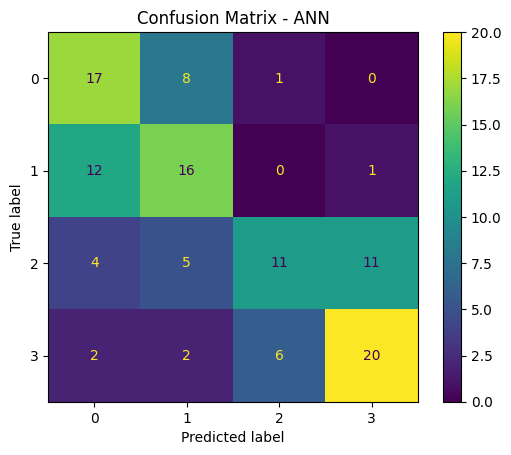

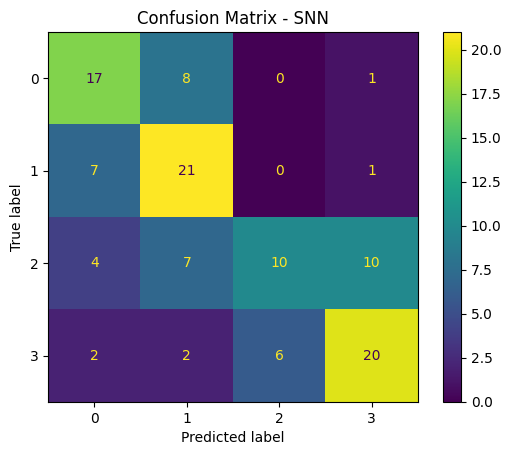



ANN accuracy: Test: 55.1700%
SNN accuracy: max_norm: 58.6207%


In [ ]:
"""
An example for the pipeline pf ANN to SNN Conversion Framework.
"""

def framework_pipeline(train_x, train_y, test_x, test_y, epoch=200, batch=64, T=100):
    """
        ANN to SNN Conversion framework
    input:
        train_x, test_x (float): Train and test data, shape as: samples*length*ch (samples*ch*length).
        train_y, test_y (int): Train and test label, shape as: samples, ie.: [0, 1, 1, 0, ..., 2].
        epoch (int): Total train and test epoch
        batch (int): Batch size
        T (int): Time step for SNN
    output:
        None
    """
    ann_model = LENet(classes_num=4).to(device)
    ann_model.apply(initialize_weights)

    train_acc, test_acc, model_trained = train_ann(ann_model, train_x, train_y, test_x, test_y, ep=epoch, batch=batch)
    max_norm_acc = anntosnn(model_trained, train_x, train_y, test_x, test_y, batch=batch, T=T)
    snn_model = ann2snn.Converter(mode='max', dataloader=data_loader(train_x, train_y, batch=batch))(model_trained)

    # Get ANN predictions
    ann_model.eval()
    ann_predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, targets in data_loader(test_x, test_y, batch=batch, shuffle=False, drop=False):
            outputs = ann_model(inputs)
            _, predicted = outputs.max(1)
            ann_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())

    # Get SNN predictions
    snn_predictions = []
    with torch.no_grad():
        for inputs, targets in data_loader(test_x, test_y, batch=batch, shuffle=False, drop=False):
          for m in snn_model.modules():
              if hasattr(m, 'reset'):
                  m.reset()
          for t in range(T):
              if t == 0:
                  outputs = snn_model(inputs)
              else:
                  outputs += snn_model(inputs)
          _, predicted = outputs.max(1)
          snn_predictions.extend(predicted.cpu().numpy())


    # Confusion Matrix for ANN
    cm_ann = confusion_matrix(true_labels, ann_predictions)
    disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann)
    disp_ann.plot()
    plt.title('Confusion Matrix - ANN')
    plt.show()

    # Confusion Matrix for SNN
    cm_snn = confusion_matrix(true_labels, snn_predictions)
    disp_snn = ConfusionMatrixDisplay(confusion_matrix=cm_snn)
    disp_snn.plot()
    plt.title('Confusion Matrix - SNN')
    plt.show()

    print('\n')
    print('ANN accuracy: Test: %.4f%%' % (test_acc * 100))
    print('SNN accuracy: max_norm: %.4f%%' % (max_norm_acc[-1] * 100))


# Getting real samples
file = scio.loadmat('/content/A01T.mat')
all_data = file['all_data']
all_label = file['all_label']

datasetX = torch.tensor(all_data, dtype=torch.float32)
datasetY = torch.tensor(all_label, dtype=torch.int64)
train_data, test_data, train_label, test_label = train_test_split(datasetX, datasetY, test_size=0.4, shuffle=True,
                                                                  random_state=0)

# ANN to SNN Conversion
framework_pipeline(train_data, train_label, test_data, test_label, epoch=100, batch=64, T=100)